In [1]:
# Bases on: https://www.kaggle.com/code/ljlbarbosa/convolution-autoencoder-pytorch/notebook

import numpy as np

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision import datasets, transforms
import torch.nn.functional as F

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# convert data to torch.FloatTensor and normalize data
transform = transforms.ToTensor()

# load the training and test datasets
train_data = datasets.FashionMNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.FashionMNIST(root='data', train=False,
                                  download=True, transform=transform)
# how many samples per batch to load
batch_size = 20

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

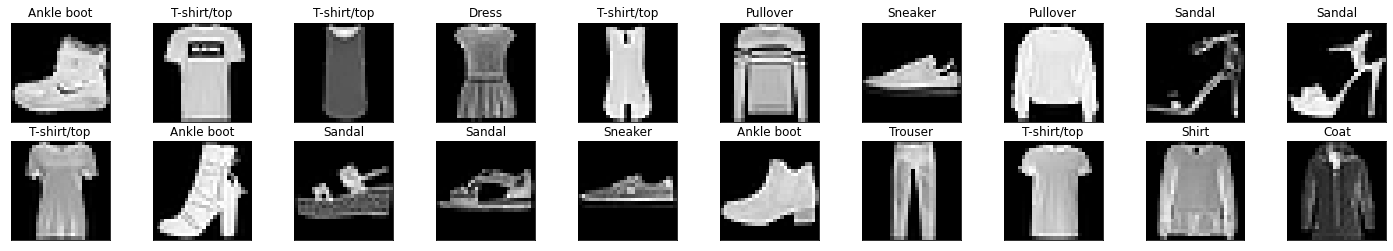

In [9]:
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    img = img[0,]
    plt.imshow(img, cmap="gray")  # convert from Tensor image

classes = datasets.FashionMNIST.classes


# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [10]:
# define the NN architecture
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        ## encoder layers ##
        # conv layer (depth from 1 --> 16), 3x3 kernels
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        # conv layer (depth from 16 --> 4), 3x3 kernels
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)

        ## decoder layers ##
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 1, 2, stride=2)

    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        # and maxpooling after
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # add second hidden layer
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # compressed representation

        ## decode ##
        # add transpose conv layers, with relu activation function
        x = F.relu(self.t_conv1(x))
        # output layer (with sigmoid for scaling from 0 to 1)
        x = F.sigmoid(self.t_conv2(x))

        return x

# initialize the NN
model = ConvAutoencoder()
print(model)

ConvAutoencoder(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
)


In [11]:
# specify loss function
criterion = nn.BCELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [12]:
# number of epochs to train the model
n_epochs = 100

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0

    ###################
    # train the model #
    ###################
    for data in train_loader:
        # _ stands in for labels, here
        # no need to flatten images
        images, _ = data

        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
        # calculate the loss
        loss = criterion(outputs, images)

        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()

        # update running training loss
        train_loss += loss.item()*images.size(0)

    # print avg training statistics
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch,
        train_loss
        ))

Epoch: 1 	Training Loss: 6.269485
Epoch: 2 	Training Loss: 5.728126
Epoch: 3 	Training Loss: 5.665540
Epoch: 4 	Training Loss: 5.627654
Epoch: 5 	Training Loss: 5.603987
Epoch: 6 	Training Loss: 5.585025
Epoch: 7 	Training Loss: 5.572758
Epoch: 8 	Training Loss: 5.563643
Epoch: 9 	Training Loss: 5.556364
Epoch: 10 	Training Loss: 5.547292
Epoch: 11 	Training Loss: 5.541712
Epoch: 12 	Training Loss: 5.537399
Epoch: 13 	Training Loss: 5.533126
Epoch: 14 	Training Loss: 5.528415
Epoch: 15 	Training Loss: 5.522842
Epoch: 16 	Training Loss: 5.516690
Epoch: 17 	Training Loss: 5.509727
Epoch: 18 	Training Loss: 5.502961
Epoch: 19 	Training Loss: 5.495111
Epoch: 20 	Training Loss: 5.487593
Epoch: 21 	Training Loss: 5.481188
Epoch: 22 	Training Loss: 5.475618
Epoch: 23 	Training Loss: 5.467669
Epoch: 24 	Training Loss: 5.461923
Epoch: 25 	Training Loss: 5.457727
Epoch: 26 	Training Loss: 5.454204
Epoch: 27 	Training Loss: 5.451197
Epoch: 28 	Training Loss: 5.448600
Epoch: 29 	Training Loss: 5.4

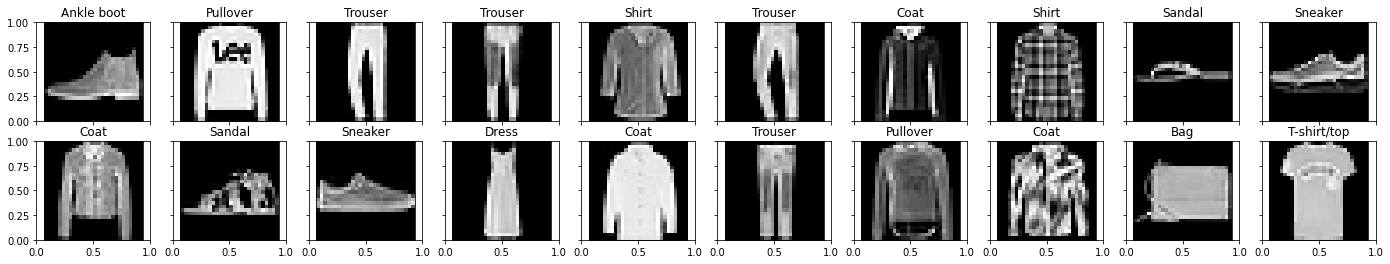

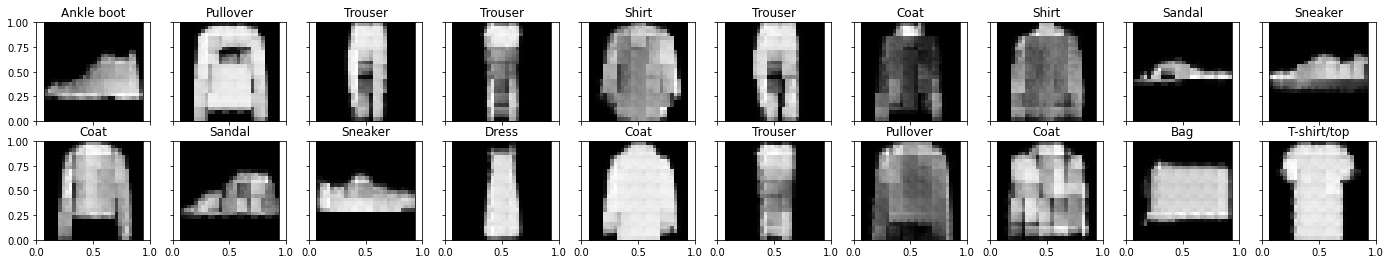

In [8]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# prep images for display
images = images.numpy()


# output is resized into a batch of iages
output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# # plot the first ten input images and then reconstructed images
# fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(24,4))

# # input images on top row, reconstructions on bottom
# for images, row in zip([images, output], axes):
#     for img, ax in zip(images, row):
#         ax.imshow(np.squeeze(img))
#         ax.get_xaxis().set_visible(False)
#         ax.get_yaxis().set_visible(False)

# plot the first ten input images and then reconstructed images
def plot_images(images, classes, n=20, nrows=2, ncols=10, sharex=True, sharey=True, figsize=(24,4)):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=sharex, sharey=sharey, figsize=figsize)
    for idx in np.arange(n):
        ax = fig.add_subplot(nrows, ncols, idx+1, xticks=[], yticks=[])
        imshow(images[idx])
        ax.set_title(classes[labels[idx]])

plot_images(images, classes, n=20, nrows=2, ncols=10, sharex=True, sharey=True, figsize=(24,4))
plot_images(output, classes, n=20, nrows=2, ncols=10, sharex=True, sharey=True, figsize=(24,4))